In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data import stock_data
from wfwGARCH import clusteringTest, GARCHWalkForward
from hvPred import HVmodel

In [6]:
con = sqlite3.connect("stock_data.db", check_same_thread=False)

In [7]:
finance = [
    "JPM",  # JPMorgan Chase
    "BAC",  # Bank of America
    "C",    # Citigroup
    "GS",   # Goldman Sachs
    "MS",   # Morgan Stanley
    "AXP",  # American Express
    "WFC",  # Wells Fargo
    "USB",  # U.S. Bancorp
    "PNC",  # PNC Financial Services
    "SCHW"  # Charles Schwab
]

tech = [
    "AAPL",  # Apple
    "MSFT",  # Microsoft
    "NVDA",  # Nvidia
    "GOOGL", # Alphabet (Google)
    "AMD",   # Advanced Micro Devices
    "INTC",  # Intel
    "TSLA",  # Tesla (tech-adjacent)
    "CRM",   # Salesforce
    "ORCL",  # Oracle
    "AVGO"   # Broadcom
]

etf = [
    "SPY",   # S&P 500 ETF
    "QQQ",   # Nasdaq 100 ETF
    "IWM",   # Russell 2000 ETF
    "VXX",   # Volatility ETF
    "XLK",   # Technology Sector ETF
    "XLF",   # Financial Sector ETF
    "ARKK",  # ARK Innovation ETF
    "DIA",   # Dow Jones ETF
    "EEM",   # Emerging Markets ETF
    "TLT"    # 20+ Year Treasury Bond ETF
]

health_tech = [
    "MRNA",  # Moderna Inc.
    "BIIB",  # Biogen Inc.
    "VRTX",  # Vertex Pharmaceuticals
    "REGN",  # Regeneron Pharmaceuticals
    "ILMN",  # Illumina Inc.
    "DXCM",  # Dexcom Inc.
    "CRSP",  # CRISPR Therapeutics (mid-cap but very volatile)
    "NVCR"   # NovoCure Ltd. (mid-cap, high volatility)
]

commodity = [
    # Energy
    "XOM",  # Exxon Mobil
    "CVX",  # Chevron
    "SLB",  # Schlumberger

    # Metals & Mining
    "NEM",  # Newmont Corporation (Gold)
    "GOLD", # Barrick Gold
    "FCX",  # Freeport-McMoRan (Copper)

    # Agriculture
    "ADM",  # Archer Daniels Midland
    "MOS",  # Mosaic (Fertilizers)
    "BG"    # Bunge Ltd.
]


In [8]:
all_stocks = finance + tech + etf + health_tech +commodity

## Load data for different sectors

In [9]:
def get_stock_data(stock_list):
    df_dict = {}
    for stock in stock_list:
        st = stock_data(stock)
        df = st.load_data(con)
        df.index = pd.to_datetime(df.index, format='ISO8601')
        df.sort_index(inplace=True)
        df_dict[stock] = df
        df_dict[stock]['returns'] = np.log(df['close'] / df['close'].shift(1))*100 
        df_dict[stock].dropna(inplace=True)
    return df_dict

In [11]:
df_finance = get_stock_data(finance)
df_tech = get_stock_data(tech)
df_etf = get_stock_data(etf)
df_health_tech = get_stock_data(health_tech)
df_commodity = get_stock_data(commodity)

In [17]:
def HVandGARCHresults(stock_list, sector):
    res = {}
    for st in stock_list.keys():
        df = stock_list[st]

        ct = clusteringTest(df['returns'])
        score = ct.clusteringScore()

        garch = GARCHWalkForward(df)
        pred, params, resids = garch.fit_garch()
        mae_garch, mse_garch, rmse_garch, qlike_garch = garch.evaluate_model(pred)

        hv = HVmodel(df)
        hv_pred = hv.HVpred()
        mae_hv, mse_hv, rmse_hv, qlike_hv = hv.evaluate_model(hv_pred)

        res[st] = [sector,len(df), score, mae_hv, mae_garch, mse_hv, mse_garch, rmse_hv, rmse_garch, qlike_hv, qlike_garch]
        print(f"Done with {st}")
    return res

    
    

In [18]:
finance_results = HVandGARCHresults(df_finance, sector="Finance")

Done with JPM
Done with BAC
Done with C
Done with GS
Done with MS


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

Done with AXP
Done with WFC
Done with USB
Done with PNC
Done with SCHW


In [19]:
df_finance_res=pd.DataFrame.from_dict(finance_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [20]:
df_finance_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [21]:
df_finance_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
GS,Finance,6463,1.069,0.645549,0.662985,0.741271,0.680328,0.860971,0.824820,1.850416,1.828301
JPM,Finance,6463,0.697,0.601149,0.643367,0.669795,0.681654,0.818410,0.825623,1.627885,1.608657
SCHW,Finance,6463,0.611,0.785880,0.842727,1.138021,1.088821,1.066781,1.043466,2.180044,2.160438
USB,Finance,6463,0.609,0.769365,0.778431,1.015652,0.955646,1.007796,0.977572,2.040883,2.016240
PNC,Finance,6463,0.581,0.675412,0.678642,0.737803,0.694186,0.858955,0.833178,1.938292,1.908653
MS,Finance,6463,0.493,0.684007,0.780179,0.777779,0.884416,0.881918,0.940434,1.919016,1.933726
BAC,Finance,6463,0.391,0.674491,0.903092,0.796387,1.039593,0.892405,1.019605,1.892545,1.995986
WFC,Finance,6463,0.186,0.785512,0.913394,1.003850,1.276647,1.001923,1.129888,2.103199,2.129798
AXP,Finance,6463,0.020,0.775508,0.813136,1.076417,1.059235,1.037505,1.029192,1.924263,1.907472
C,Finance,6463,0.008,0.737551,2.449025,1.017220,6.349885,1.008573,2.519898,2.001117,2.868450


In [22]:
tech_results = HVandGARCHresults(df_tech, sector="Technology")

Done with AAPL
Done with MSFT


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

Done with NVDA


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

Done with GOOGL
Done with AMD
Done with INTC


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

Done with TSLA


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

Done with CRM
Done with ORCL


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

Done with AVGO


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

In [23]:
df_tech_res=pd.DataFrame.from_dict(tech_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [24]:
df_tech_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [25]:
df_tech_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
AMD,Technology,6463,0.115,1.142432,1.311252,2.086804,2.289806,1.444578,1.513210,2.982179,3.031322
INTC,Technology,6463,0.092,1.073017,1.144087,2.038567,2.367326,1.427784,1.538612,2.436616,2.448467
ORCL,Technology,6463,0.092,0.822166,0.891446,1.235266,1.293888,1.111425,1.137492,1.908306,1.896490
MSFT,Technology,6463,0.034,0.613676,0.720640,0.613412,0.723483,0.783206,0.850578,1.631983,1.684977
TSLA,Technology,3783,0.021,1.982361,2.779887,16.262666,13.635730,4.032700,3.692659,3.371540,3.602002
NVDA,Technology,6463,0.002,2.407239,2.826380,53.037301,55.989178,7.282671,7.482592,3.090181,3.264670
AAPL,Technology,6463,-0.000,1.084809,2.866650,12.484022,9.997182,3.533274,3.161832,1.837558,2.976195
CRM,Technology,5298,-0.000,0.848458,1.539975,1.278365,3.219861,1.130648,1.794397,2.165728,2.481067
AVGO,Technology,4008,-0.000,2.301557,3.301406,59.678934,58.089578,7.725214,7.621652,2.593728,2.861171
GOOGL,Technology,5258,-0.001,2.003510,3.087341,83.664811,30.945484,9.146847,5.562867,2.016613,2.912731


In [26]:
etf_results = HVandGARCHresults(df_etf, sector="ETF")

Done with SPY
Done with QQQ
Done with IWM


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Done with VXX
Done with XLK
Done with XLF
Done with ARKK
Done with DIA
Done with EEM
Done with TLT


In [27]:
df_etf_res=pd.DataFrame.from_dict(etf_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [28]:
df_etf_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [29]:
df_etf_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
DIA,ETF,6465,1.615,0.371688,0.365330,0.248860,0.214512,0.498859,0.463154,0.484313,0.447205
SPY,ETF,6458,1.528,0.431719,0.417018,0.338760,0.285305,0.582031,0.534139,0.670078,0.623520
TLT,ETF,5780,1.507,0.433813,0.423719,0.248099,0.224830,0.498095,0.474163,0.423621,0.414331
XLF,ETF,6465,1.290,0.474614,0.500219,0.406460,0.402143,0.637542,0.634147,1.021564,1.018399
ARKK,ETF,2691,1.269,0.935919,0.923978,1.458779,1.339081,1.207799,1.157187,2.439832,2.410310
XLK,ETF,6465,1.219,0.594474,0.574514,0.602777,0.523449,0.776387,0.723498,1.365983,1.340590
QQQ,ETF,6457,0.034,0.537311,0.557618,0.498733,0.491822,0.706210,0.701300,1.235093,1.232524
IWM,ETF,6321,0.014,0.511587,0.694744,0.431969,0.610350,0.657243,0.781249,1.410277,1.547524
EEM,ETF,5600,0.002,0.574547,2.106991,0.464774,4.522216,0.681744,2.126550,0.536870,2.047387
VXX,ETF,4140,-0.008,2.877314,4.578181,43.991338,23.065777,6.632597,4.802684,3.444660,4.141465


In [30]:
health_tech_results = HVandGARCHresults(df_health_tech, sector="Health Tech")

Done with MRNA
Done with BIIB


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Done with VRTX
Done with REGN
Done with ILMN
Done with DXCM
Done with CRSP
Done with NVCR


In [31]:
df_health_tech_res=pd.DataFrame.from_dict(health_tech_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [32]:
df_health_tech_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [33]:
df_health_tech_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
MRNA,Health Tech,1658,0.558,1.643101,1.675909,4.128936,3.750205,2.031978,1.936545,3.714262,3.612073
CRSP,Health Tech,2196,0.286,1.252213,1.336058,2.624235,2.578795,1.619949,1.605863,3.439195,3.427970
REGN,Health Tech,6464,0.183,0.679869,0.908899,0.930229,1.258453,0.964484,1.121808,2.104067,2.122069
ILMN,Health Tech,6277,0.166,1.021008,1.362843,1.826786,2.695453,1.351586,1.641783,2.841136,2.870049
VRTX,Health Tech,6464,0.119,0.688320,0.969282,0.921256,1.223013,0.959821,1.105899,1.973044,2.052096
NVCR,Health Tech,2460,0.065,2.043478,1.791019,8.377351,4.491629,2.894365,2.119346,3.896387,3.731877
BIIB,Health Tech,6464,0.043,0.958800,1.390709,4.057909,4.496446,2.014425,2.120482,2.602772,2.522034
DXCM,Health Tech,5095,0.004,1.748718,2.294009,21.487656,21.797871,4.635478,4.668819,2.878984,3.008090


In [34]:
commodity_results = HVandGARCHresults(df_commodity, sector="Commodity")

Done with XOM
Done with CVX


/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projects/stock_project/.venv/lib/python3.9/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/susmitasingh/Documents/Documents/job_prep/projec

Done with SLB
Done with NEM
Done with GOLD
Done with FCX
Done with ADM
Done with MOS
Done with BG


In [35]:
df_comodity_res=pd.DataFrame.from_dict(commodity_results, orient='index', columns=["Sector",'Observations','Clustering Score','MAE (HV)','MAE (GARCH)','MSE (HV)','MSE (GARCH)','RMSE (HV)','RMSE (GARCH)','QLIKE (HV)','QLIKE (GARCH)'])

In [36]:
df_comodity_res.sort_values(by='Clustering Score',ascending=False, inplace=True)

In [37]:
df_comodity_res

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
BG,Commodity,6023,0.815,0.605274,0.628410,0.659009,0.599483,0.811794,0.774263,2.080879,2.040923
NEM,Commodity,6465,0.717,0.819959,0.848824,1.089036,1.003845,1.043569,1.001921,2.232684,2.209052
ADM,Commodity,6465,0.538,0.646245,0.669485,0.926500,0.740778,0.962549,0.860685,1.799603,1.777379
MOS,Commodity,6465,0.527,0.922656,0.952572,1.376643,1.353141,1.173304,1.163246,2.766215,2.750674
FCX,Commodity,6465,0.168,1.016387,1.206928,1.618613,1.974197,1.272247,1.405061,2.646512,2.719180
SLB,Commodity,6465,0.096,0.912712,1.051504,1.396421,1.615848,1.181703,1.271160,2.542775,2.568974
CVX,Commodity,6465,0.072,0.619972,0.713535,0.621159,0.651670,0.788136,0.807261,1.715394,1.774914
GOLD,Commodity,4134,0.041,0.893808,1.364661,1.126348,2.364761,1.061295,1.537778,1.917299,2.191926
XOM,Commodity,6465,0.038,0.644848,0.852400,0.680262,1.242319,0.824780,1.114593,1.858216,1.973030


In [56]:
df_all_sectors_res = pd.concat([
    df_finance_res,
    df_tech_res,
    df_etf_res,
    df_health_tech_res,
    df_comodity_res
])

In [57]:
# df_all_sectors_res.reset_index(inplace=True)
df_all_sectors_res.rename(columns={"index":"Ticker"},inplace=True)

In [61]:
df_all_sectors_res.to_csv("results/all_sectors_results.csv", index=True)

In [62]:
df_all_sectors_res.sort_values(by="Clustering Score", ascending=False, inplace=True)

In [63]:
df_all_sectors_res.head(10)

,Sector,Observations,Clustering Score,MAE (HV),MAE (GARCH),MSE (HV),MSE (GARCH),RMSE (HV),RMSE (GARCH),QLIKE (HV),QLIKE (GARCH)
DIA,ETF,6465,1.615,0.371688,0.365330,0.248860,0.214512,0.498859,0.463154,0.484313,0.447205
SPY,ETF,6458,1.528,0.431719,0.417018,0.338760,0.285305,0.582031,0.534139,0.670078,0.623520
TLT,ETF,5780,1.507,0.433813,0.423719,0.248099,0.224830,0.498095,0.474163,0.423621,0.414331
XLF,ETF,6465,1.290,0.474614,0.500219,0.406460,0.402143,0.637542,0.634147,1.021564,1.018399
ARKK,ETF,2691,1.269,0.935919,0.923978,1.458779,1.339081,1.207799,1.157187,2.439832,2.410310
XLK,ETF,6465,1.219,0.594474,0.574514,0.602777,0.523449,0.776387,0.723498,1.365983,1.340590
GS,Finance,6463,1.069,0.645549,0.662985,0.741271,0.680328,0.860971,0.824820,1.850416,1.828301
BG,Commodity,6023,0.815,0.605274,0.628410,0.659009,0.599483,0.811794,0.774263,2.080879,2.040923
NEM,Commodity,6465,0.717,0.819959,0.848824,1.089036,1.003845,1.043569,1.001921,2.232684,2.209052
JPM,Finance,6463,0.697,0.601149,0.643367,0.669795,0.681654,0.818410,0.825623,1.627885,1.608657


In [106]:
df_deltaQLIKE = df_all_sectors_res[[ "Sector", "Clustering Score"]]

In [107]:
df_deltaQLIKE["delta QLIKE"] =(df_all_sectors_res["QLIKE (HV)"]-df_all_sectors_res["QLIKE (GARCH)"])/df_all_sectors_res["QLIKE (HV)"]

In [108]:
df_deltaQLIKE.to_csv("results/deltaQLIKE.csv", index=True)

In [110]:
df_deltaQLIKE["pctQLIKE"]=df_deltaQLIKE["delta QLIKE"]*100

In [128]:
df_deltaQLIKE[df_deltaQLIKE["Sector"]=="Health Tech"]

,Sector,Clustering Score,delta QLIKE,pctQLIKE
MRNA,Health Tech,0.558,0.027513,2.751251
CRSP,Health Tech,0.286,0.003264,0.326386
REGN,Health Tech,0.183,-0.008556,-0.855575
ILMN,Health Tech,0.166,-0.010177,-1.017660
VRTX,Health Tech,0.119,-0.040066,-4.006602
NVCR,Health Tech,0.065,0.042221,4.222103
BIIB,Health Tech,0.043,0.031020,3.102019
DXCM,Health Tech,0.004,-0.044844,-4.484448


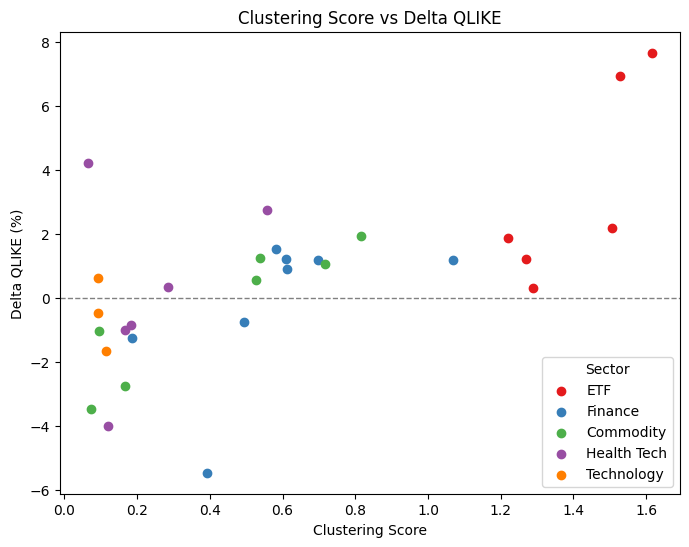

In [146]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
sectors = df_deltaQLIKE["Sector"].unique()
colors = {sector: color for sector, color in zip(sectors, plt.cm.Set1.colors)}

for sector in sectors:
    mask = df_deltaQLIKE["Sector"] == sector
    ax.scatter(
        df_deltaQLIKE[:30].loc[mask, "Clustering Score"],
        df_deltaQLIKE[:30].loc[mask, "pctQLIKE"],
        label=sector,
        color=colors[sector]
    )
ax.axhline(0, color='gray', linestyle='--', linewidth=1)  

ax.set_title('Clustering Score vs Delta QLIKE')
ax.set_xlabel('Clustering Score')
ax.set_ylabel('Delta QLIKE (%)')
ax.legend(title="Sector")
# plt.savefig("results/clustering_vs_deltaQLIKE.png", bbox_inches='tight')
plt.show()